# Modeling

---

This notebook outlines the process for creating the prediction model for predicting tax assessed property values for the Zillow dataset.

---

## Importing the Required Modules

Below we import all the modules needed to run this notebook. (Note on other user modules needed)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler

from env import username, password, hostname

## Acquire and Split Data

Here we define all our acquisition and preparation functions created in the acquire and prepare notebook.

In [2]:
def get_db_url(database_name, username = username, password = password, hostname = hostname):
    return f'mysql+pymysql://{username}:{password}@{hostname}/{database_name}'

def get_zillow_sql():
    return """
        SELECT
            bedroomcnt,
            bathroomcnt,
            calculatedfinishedsquarefeet,
            taxvaluedollarcnt,
            yearbuilt,
            fips,
            numberofstories,
            basementsqft,
            fireplacecnt,
            heatingorsystemdesc,
            roomcnt,
            garagetotalsqft,
            hashottuborspa,
            poolcnt,
            poolsizesum,
            yardbuildingsqft17
        FROM properties_2017
        JOIN propertylandusetype
            ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
            AND (propertylandusetype.propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential'))
        LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
        JOIN predictions_2017 ON properties_2017.parcelid = predictions_2017.parcelid
            AND predictions_2017.transactiondate LIKE '2017%%';
        """

def get_zillow_data(use_cache = True):
    # If the file is cached, read from the .csv file
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cache')
        return pd.read_csv('zillow.csv')
    
    # Otherwise read from the mysql database
    else:
        print('Reading from database')
        df = pd.read_sql(get_zillow_sql(), get_db_url('zillow'))
        df.to_csv('zillow.csv', index = False)
        return df
    
def prepare_zillow_data(df):
    columns = [
        'calculatedfinishedsquarefeet'
    ]

    df = remove_outliers(df, 1.5, columns)
    
    missing_target = df.taxvaluedollarcnt.isnull()
    df = df[~missing_target]
    
    missing_yearbuilt = df.yearbuilt.isnull()
    df = df[~missing_yearbuilt]
    
    df.yearbuilt.fillna(df.yearbuilt.mode()[0], inplace = True)
    df.basementsqft.fillna(0, inplace = True)
    df.fireplacecnt.fillna(0, inplace = True)
    df.hashottuborspa.fillna(0, inplace = True)
    df.poolcnt.fillna(0, inplace = True)
    
    df = df.drop(columns = 'numberofstories')
    df = df.drop(columns = 'heatingorsystemdesc')
    df = df.drop(columns = 'garagetotalsqft')
    df = df.drop(columns = 'poolsizesum')
    df = df.drop(columns = 'yardbuildingsqft17')
    df = df.drop(columns = 'roomcnt')
    
    df.yearbuilt = df.yearbuilt.astype('int')
    df.bedroomcnt = df.bedroomcnt.astype('int')
    df.fips = df.fips.astype('int')
    df.fireplacecnt = df.fireplacecnt.astype('int')
    df.hashottuborspa = df.hashottuborspa.astype('int')
    df.poolcnt = df.poolcnt.astype('int')

    # Rename the columns for readability
    df = df.rename(columns = {
        'bedroomcnt' : 'bedroom_count',
        'bathroomcnt' : 'bathroom_count',
        'calculatedfinishedsquarefeet' : 'square_feet',
        'taxvaluedollarcnt' : 'property_tax_assessed_values',
        'yearbuilt' : 'year_built',
        'fips' : 'fed_code',
        'basementsqft' : 'basement_square_feet',
        'fireplacecnt' : 'fireplace_count',
        'hashottuborspa' : 'has_hot_tub',
        'poolcnt' : 'has_pool'
    })
    
    return df

def remove_outliers(df, k, col_list):
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [3]:
def split_data(df, random_seed = 24, stratify = None):
    test_split = 0.2
    train_validate_split = 0.3

    train_validate, test = train_test_split(
        df,
        test_size = test_split,
        random_state = random_seed,
        stratify = stratify if not stratify else df[stratify]
    )
    train, validate = train_test_split(
        train_validate,
        test_size = train_validate_split,
        random_state = random_seed,
        stratify = stratify if not stratify else train_validate[stratify]
    )
    return train, validate, test

def scale_data(train, validate, test):
    scaler = MinMaxScaler()
    numeric_columns = train.select_dtypes('number').columns
    
    train[numeric_columns] = scaler.fit_transform(train[numeric_columns])
    validate[numeric_columns] = scaler.transform(validate[numeric_columns])
    test[numeric_columns] = scaler.transform(test[numeric_columns])
    
    return train, validate, test

Now we can acquire, prepare, and split our data.

In [4]:
train, validate, test = split_data(prepare_zillow_data(get_zillow_data()))
# train, validate, test = scale_data(train, validate, test)
train.shape, validate.shape, test.shape

Using cache


((28023, 10), (12010, 10), (10009, 10))

In [5]:
# train = remove_outliers(train, 3.0, ['property_tax_assessed_values'])
# train.shape

In [6]:
features = [
    'square_feet',
    'bedroom_count',
    'bathroom_count',
    'year_built',
    'has_hot_tub',
    'has_pool',
    'fed_code'
]

X_train, y_train = train[features], train.property_tax_assessed_values
X_validate, y_validate = validate[features], validate.property_tax_assessed_values
X_test, y_test = test[features], test.property_tax_assessed_values

X_train, X_validate, X_test = scale_data(X_train, X_validate, X_test)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

## Create a Baseline

In [7]:
baseline = pd.DataFrame({
    'median' : [y_train.median()] * y_train.size,
    'mean' : [y_train.mean()] * y_train.size
})
baseline.shape

(28023, 2)

In [8]:
print(f'RMSE median baseline: {mean_squared_error(y_train, baseline["median"], squared = False)}')
print(f'RMSE mean baseline: {mean_squared_error(y_train, baseline["mean"], squared = False)}')

RMSE median baseline: 454986.46176328306
RMSE mean baseline: 445002.7946509774


We'll use the mean as our baseline.

## Feature Selection

In [9]:
lm = LinearRegression()

rfe = RFE(lm, n_features_to_select = 2)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [10]:
pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=X_train.columns)

,rfe_ranking
square_feet,1
bedroom_count,1
bathroom_count,2
year_built,3
has_hot_tub,4
has_pool,5
fed_code,6


## Creating the Models

In [11]:
results = {
    'baseline' : {
        'RMSE' : mean_squared_error(y_train, baseline['mean'], squared = False),
        'R^2' : r2_score(y_train, baseline['mean'])
    }
}

feature_set_1 = [
    'has_hot_tub',
    'has_pool',
    'bathroom_count',
    'bedroom_count',
    'year_built',
    'square_feet',
    'fed_code'
]

feature_set_2 = [
    'bedroom_count',
    'bathroom_count',
    'square_feet'
]

feature_set_3 = [
    'bedroom_count',
    'bathroom_count',
    'year_built',
    'square_feet'
]

### Target Distribution

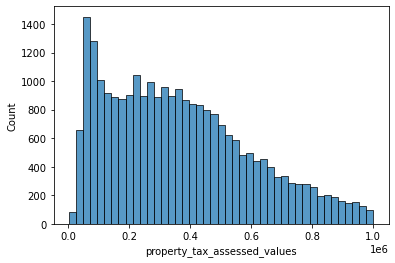

In [12]:
mask = y_train < 1_000_000
sns.histplot(y_train[mask]);

### Linear Regression

In [13]:
model = LinearRegression()
model.fit(X_train[feature_set_1], y_train)

r2_score(y_train, model.predict(X_train[feature_set_1]))

0.2504509051298175

In [14]:
mean_squared_error(y_train, model.predict(X_train[feature_set_1]), squared = False)

385267.8598398008

In [15]:
results['linear_regression_1'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_set_1]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_set_1])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_set_1]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_set_1]))
}

In [16]:
model = LinearRegression()
model.fit(X_train[feature_set_2], y_train)

r2_score(y_train, model.predict(X_train[feature_set_2]))

0.2376845060408853

In [17]:
mean_squared_error(y_train, model.predict(X_train[feature_set_2]), squared = False)

388534.96851418185

In [18]:
results['linear_regression_2'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_set_2]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_set_2])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_set_2]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_set_2]))
}

In [19]:
model = LinearRegression()
model.fit(X_train[feature_set_3], y_train)

r2_score(y_train, model.predict(X_train[feature_set_3]))

0.24817495788265986

In [20]:
mean_squared_error(y_train, model.predict(X_train[feature_set_3]), squared = False)

385852.3343715859

In [21]:
results['linear_regression_3'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_set_3]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_set_3])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_set_3]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_set_3]))
}

In [22]:
model = LinearRegression(normalize = True)
model.fit(X_train[feature_set_3], y_train)

r2_score(y_train, model.predict(X_train[feature_set_3]))

0.24817495788265997

### LassoLars

In [23]:
model = LassoLars(alpha = 1.0)
model.fit(X_train[feature_set_1], y_train)

r2_score(y_train, model.predict(X_train[feature_set_1]))

0.25044915466309636

In [24]:
mean_squared_error(y_train, model.predict(X_train[feature_set_1]), squared = False)

385268.30970904767

In [25]:
results['lasso_lars_1'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_set_1]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_set_1])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_set_1]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_set_1]))
}

In [26]:
model = LassoLars(alpha = 1.0)
model.fit(X_train[feature_set_2], y_train)

r2_score(y_train, model.predict(X_train[feature_set_2]))

0.23768367464656925

In [27]:
mean_squared_error(y_train, model.predict(X_train[feature_set_2]), squared = False)

388535.1803855651

In [28]:
results['lasso_lars_2'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_set_2]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_set_2])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_set_2]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_set_2]))
}

In [29]:
model = LassoLars(alpha = 1.0)
model.fit(X_train[feature_set_3], y_train)

r2_score(y_train, model.predict(X_train[feature_set_3]))

0.24817369018304447

In [30]:
mean_squared_error(y_train, model.predict(X_train[feature_set_3]), squared = False)

385852.6596764256

In [31]:
results['lasso_lars_3'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_set_3]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_set_3])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_set_3]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_set_3]))
}

In [32]:
model = LassoLars(alpha = 2.0)
model.fit(X_train[feature_set_3], y_train)

r2_score(y_train, model.predict(X_train[feature_set_3]))

0.24816988708419863

In [33]:
mean_squared_error(y_train, model.predict(X_train[feature_set_3]), squared = False)

385853.63558929926

In [34]:
model = LassoLars(alpha = 5.0)
model.fit(X_train[feature_set_3], y_train)

r2_score(y_train, model.predict(X_train[feature_set_3]))

0.24814326539227716

### Polynomial Regression

In [35]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train)

X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns = poly.get_feature_names(X_train.columns),
    index = X_train.index
)

model = LinearRegression()

rfe = RFE(model, n_features_to_select = 4)
rfe.fit(X_train_poly, y_train)

X_train_rfe = rfe.transform(X_train_poly)
model.fit(X_train_rfe, y_train)

r2_score(y_train, model.predict(X_train_rfe))

0.2590419806846168

In [36]:
mean_squared_error(y_train, model.predict(X_train_rfe), squared = False)

383053.5924915374

In [37]:
X_validate_poly = pd.DataFrame(
    poly.transform(X_validate),
    columns = poly.get_feature_names(X_validate.columns),
    index = X_validate.index
)

rfe = RFE(model, n_features_to_select = 4)
rfe.fit(X_validate_poly, y_validate)

X_validate_rfe = rfe.transform(X_validate_poly)

In [38]:
results['polynomial_regression_1'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_rfe), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_rfe)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_rfe), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_rfe))
}

In [39]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train)

X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns = poly.get_feature_names(X_train.columns),
    index = X_train.index
)

model = LinearRegression()

model.fit(X_train_poly, y_train)

r2_score(y_train, model.predict(X_train_poly))

0.27901465081205723

In [40]:
mean_squared_error(y_train, model.predict(X_train_poly), squared = False)

377855.6828231103

In [41]:
X_validate_poly = pd.DataFrame(
    poly.transform(X_validate),
    columns = poly.get_feature_names(X_validate.columns),
    index = X_validate.index
)

In [42]:
results['polynomial_regression_2'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_poly))
}

In [43]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
poly.fit(X_train)

X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns = poly.get_feature_names(X_train.columns),
    index = X_train.index
)

model = LinearRegression()

model.fit(X_train_poly, y_train)

r2_score(y_train, model.predict(X_train_poly))

0.2743852239777488

In [44]:
mean_squared_error(y_train, model.predict(X_train_poly), squared = False)

379066.8421335632

In [45]:
X_validate_poly = pd.DataFrame(
    poly.transform(X_validate),
    columns = poly.get_feature_names(X_validate.columns),
    index = X_validate.index
)

In [46]:
results['polynomial_regression_3'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_poly))
}

## Results

In [47]:
pd.DataFrame(results).T

,RMSE,R^2,RMSE_val,R^2_val
baseline,445002.794651,0.000000,NaN,NaN
linear_regression_1,385267.859840,0.250451,407851.552746,0.237387
linear_regression_2,388534.968514,0.237685,410961.017768,0.225715
linear_regression_3,385852.334372,0.248175,408266.661258,0.235834
lasso_lars_1,385268.309709,0.250449,407859.288843,0.237359
lasso_lars_2,388535.180386,0.237684,410968.226261,0.225688
lasso_lars_3,385852.659676,0.248174,408275.028145,0.235803
polynomial_regression_1,383053.592492,0.259042,410508.339927,0.227420
polynomial_regression_2,377855.682823,0.279015,398181.331960,0.273122
polynomial_regression_3,379066.842134,0.274385,399732.883922,0.267446
